<a href="https://colab.research.google.com/github/dchlseo/DataScienceProjects/blob/main/DeepLearningBasics/TensorFlow/07_subclass_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Subclass modeling in TensorFlow
- https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

### Linear regression using layers

In [15]:
class LinearRegression(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LinearRegression, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = tf.Variable(0.0)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [16]:
# mock data
W_true = np.array([[3., 2., 4., 1.]]).reshape((4, 1))
B_true = np.array([1.])

X = tf.random.normal((500, 4))
noise = tf.random.normal((500, 1))

y = X @ W_true + B_true + noise

In [18]:
# Define the optimizer to be used for gradient descent.
# Here, Stochastic Gradient Descent (SGD) is used with a learning rate of 0.03.
opt = tf.keras.optimizers.SGD(learning_rate=3e-2)

# Instantiate the custom LinearRegression layer with one output unit.
linear_layer = LinearRegression(1)

# Run a training loop for 100 epochs.
for epoch in range(100):
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:
        # Call the linear_layer to compute predictions (y_hat) given inputs (X).
        y_hat = linear_layer(X)
        # Compute the mean squared error (loss) between the predictions and the actual targets (y).
        loss = tf.reduce_mean(tf.square((y - y_hat)))
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss, linear_layer.trainable_weights)

    # Apply the gradients to the variables using the SGD optimizer.
    opt.apply_gradients(zip(grads, linear_layer.trainable_weights))

    if epoch % 10 == 0:
        print("epoch : {} loss : {}".format(epoch, loss.numpy()))

epoch : 0 loss : 31.27263641357422
epoch : 10 loss : 10.203272819519043
epoch : 20 loss : 3.7826313972473145
epoch : 30 loss : 1.8218048810958862
epoch : 40 loss : 1.2217427492141724
epoch : 50 loss : 1.0377455949783325
epoch : 60 loss : 0.9812194108963013
epoch : 70 loss : 0.963822603225708
epoch : 80 loss : 0.9584589600563049
epoch : 90 loss : 0.9568027257919312


### ResNet via Sub Class
- Residual blocks -> layers
- ResNet -> model

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [23]:
class ResidualBlock(tf.keras.layers.Layer):
    """
    ResidualBlock is a custom Keras layer representing a single block in a
    Residual Network (ResNet). This block has a series of convolutional layers
    with skip connections that allow the input to bypass one or more layers.

    Attributes:
        filters (int): The number of filters to use in the convolutional layers.
        filter_match (bool): Whether to match the number of filters in the input
                             to the residual block's output. If True, a convolution
                             with a 1x1 kernel size is used to adjust the input
                             before adding it to the block's output.
        conv1 (Conv2D): The first convolutional layer with a 1x1 kernel, applied
                        to the input.
        conv2 (Conv2D): The second convolutional layer with a 3x3 kernel, applied
                        to the output of conv1.
        conv3 (Conv2D): The third convolutional layer with a 1x1 kernel, applied
                        to the output of conv2.
        add (Add): A layer that performs element-wise addition, used to merge the
                   input with the output of conv3.
        conv_ext (Conv2D): An optional convolutional layer with a 1x1 kernel that
                           is only used if filter_match is True, to adjust the input
                           filters to match the output filters of the block.
    """

    def __init__(self, filters=32, filter_match=False):
        """
        Initializes the ResidualBlock layer.

        Args:
            filters (int): The number of filters for the convolutional layers.
                           Defaults to 32.
            filter_match (bool): If set to True, will include an additional
                                 convolutional layer to match the input depth
                                 with the depth of the output of this block.
                                 Defaults to False.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        self.conv3 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')
        self.add = Add()
        self.filters = filters
        self.filter_match = filter_match
        if filter_match:
            # Define the extra convolutional layer to match the input filters
            self.conv_ext = Conv2D(filters, kernel_size=1, padding='same')

    def call(self, inputs):
        """
        Performs the forward pass through the residual block.

        Args:
            inputs (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: The output tensor of the residual block.
        """
        net1 = self.conv1(inputs)
        net2 = self.conv2(net1)
        net3 = self.conv3(net2)

        if self.filter_match:
            # If filter matching is required, adjust the inputs first
            res = self.add([self.conv_ext(inputs), net3])
        else:
            # If no filter matching is needed, directly add the inputs
            res = self.add([inputs, net3])

        return res


In [24]:
class ResNet(tf.keras.Model):
    """
    ResNet is a custom model class that extends tf.keras.Model, implementing
    a simplified version of the Residual Network architecture for image classification.

    The model includes initial convolutional and max pooling layers, followed by
    two residual blocks, another max pooling layer, and a dense layer for output.

    Attributes:
        conv1 (Conv2D): The initial convolutional layer with 32 filters and
                        a 3x3 kernel size.
        maxp1 (MaxPool2D): The first max pooling layer.
        block1 (ResidualBlock): The first residual block with filter matching,
                                which adjusts the number of filters to match
                                the block's output.
        block2 (ResidualBlock): The second residual block without filter matching.
        maxp2 (MaxPool2D): The second max pooling layer.
        flat (Flatten): A layer that flattens the input for the dense layer.
        dense (Dense): The output dense layer that predicts the class probabilities.

    Methods:
        call(inputs): Defines the forward pass of the model.
    """

    def __init__(self, num_classes):
        """
        Initializes the ResNet model.

        Args:
            num_classes (int): The number of classes for the classification task.
        """
        super(ResNet, self).__init__()
        # Initial convolution and pooling layers
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')
        self.maxp1 = MaxPool2D()

        # Residual blocks, with the first one adjusting filters to match
        self.block1 = ResidualBlock(64, filter_match=True)
        self.block2 = ResidualBlock(64)

        # Second pooling and flattening layers
        self.maxp2 = MaxPool2D()
        self.flat = Flatten()

        # Dense layer for classification with number of units equal to num_classes
        self.dense = Dense(num_classes)

    def call(self, inputs):
        """
        Defines the forward pass of the model.

        Args:
            inputs (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: The output tensor with the probability distribution over classes.
        """
        x = self.conv1(inputs)
        x = self.maxp1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.maxp2(x)
        x = self.flat(x)
        return self.dense(x)


In [25]:
model = ResNet(10)

In [26]:
class DataLoader():

  def __init__(self):
    (self.train_x, self.train_y), \
      (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()

  def validate_pixel_scale(self, x):
    return 255 >= x.max() and 0 <= x.min()

  def scale(self, x):
    return (x/255.0).astype(np.float32)  # range 0~1

  def preprocess_dataset(self, dataset):
    (feature, target) = dataset

    validated_x = np.array([x for x in feature if self.validate_pixel_scale(x)])
    validated_y = np.array([y for x, y in zip(feature, target) if self.validate_pixel_scale(x)])

    # scaling
    scaled_x = np.array([self.scale(x) for x in validated_x])

    # # expand
    # expanded_x = scaled_x[:, :, :, np.newaxis]  # new axis is for color (1=gray, 3=color)

    # label encoding
    ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in validated_y])

    return scaled_x, np.squeeze(ohe_y, axis=1)

  def get_train_dataset(self):
    return self.preprocess_dataset((self.train_x, self.train_y))

  def get_test_dataset(self):
    return self.preprocess_dataset((self.test_x, self.test_y))


In [27]:
loader = DataLoader()
train_x, train_y = loader.get_train_dataset()
test_x, test_y = loader.get_test_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [28]:
lr = 0.03
opt = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [29]:
hist = model.fit(train_x, train_y, epochs=10, batch_size=128, validation_data=(test_x, test_y))

Epoch 1/10
391/391 [==============================] - 68s 162ms/step - loss: 2.6123 - accuracy: 0.1275 - val_loss: 2.2830 - val_accuracy: 0.1366
Epoch 2/10
391/391 [==============================] - 63s 161ms/step - loss: 2.2626 - accuracy: 0.1405 - val_loss: 2.2732 - val_accuracy: 0.1086
Epoch 3/10
391/391 [==============================] - 60s 154ms/step - loss: 2.4581 - accuracy: 0.1716 - val_loss: 2.2802 - val_accuracy: 0.0987
Epoch 4/10
391/391 [==============================] - 65s 167ms/step - loss: 2.2411 - accuracy: 0.1373 - val_loss: 2.1774 - val_accuracy: 0.1468
Epoch 5/10
391/391 [==============================] - 61s 157ms/step - loss: 7.8294 - accuracy: 0.1042 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 62s 159ms/step - loss: 8.0591 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 60s 154ms/step - loss: 8.0591 - accuracy: 0.1000 - val_loss: 8.0590 - val_ac

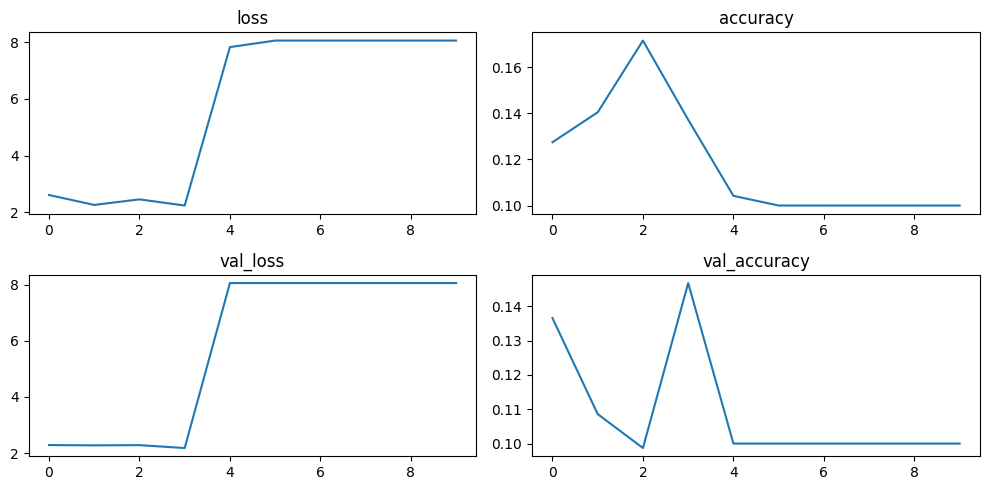

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()